# Portfolio Optimization - qaoa solution

## Import

In [31]:
from qiskit_finance.data_providers import RandomDataProvider
import datetime
import matplotlib.pyplot as plt
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit_aer.primitives import Sampler
from qiskit.result import QuasiDistribution
from qiskit_algorithms.utils import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer

import numpy as np 


## Generazione dei dati

In questa sezione, utilizziamo la classe `RandomDataProvider` di Qiskit per generare dati storici casuali relativi a un portafoglio di 8 asset fittizi. 

- **assets:** Numero di azioni nel portafoglio.
- **seed:** Valore per garantire la riproducibilità dei dati.
- **data_provider:** Simula i ritorni medi e la matrice di covarianza per il periodo specificato.

Il vettore `mu` contiene i ritorni medi per ogni asset, mentre la matrice `sigma` rappresenta la covarianza tra i ritorni.

In [32]:
assets = 8
seed = 2024

start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime(2024, 1, 30)

stocks = [("TICKER%s" % i) for i in range(assets)]
data_provider = RandomDataProvider(
    tickers=stocks,
    start=start_date,
    end=end_date,
    seed=seed,
)

data_provider.run()

## Visualizzazione della matrice di covarianza

Questa sezione utilizza Matplotlib per visualizzare la matrice di covarianza (`sigma`).

- Le celle più scure indicano una covarianza maggiore, cioè una correlazione più forte tra i rispettivi asset.

> Questo tipo di visualizzazione aiuta a comprendere il rischio sistematico del portafoglio.

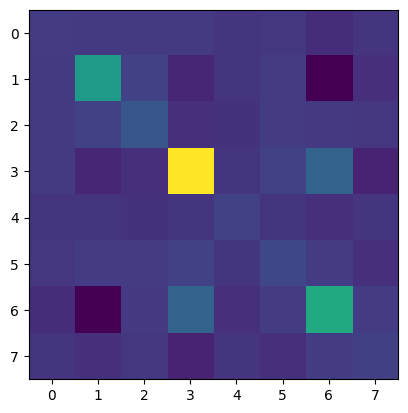

In [33]:
mu = data_provider.get_period_return_mean_vector()
sigma = data_provider.get_period_return_covariance_matrix()

# Darker cell means an higher value
plt.imshow(sigma, interpolation="nearest")
plt.show()

## Impostazione del problema di ottimizzazione

Configuriamo il problema di ottimizzazione del portafoglio utilizzando la classe `PortfolioOptimization`.

- **risk_factor:** Parametro che bilancia rischio e ritorno nell’ottimizzazione.
- **buget:** Numero massimo di asset selezionabili.

Questo problema viene convertito in un Quadratic Program, che può essere risolto sia con metodi classici che quantistici.

In [34]:
risk_factor = 0.5
# 50% of the assets
budget = assets // 2

# penalty = assets
po = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget
)
qp = po.to_quadratic_program()
# print(qp)

## Interpretazione dei risultati

Stampiamo e analizziamo i risultati dell'ottimizzazione:

- **Selection:** Array binario che indica quali asset sono stati inclusi nel portafoglio ottimale.
- **Value:** Valore ottimizzato del portafoglio.
- **Probabilities:** Nel caso di solver quantistici, probabilità associate agli autostati.

Questa sezione fornisce un riepilogo dettagliato delle scelte effettuate dal modello.

In [35]:

def print_result(result, portfolio):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

# QAOA

## Implementazione dell'ottimizzazione con QAOA

In questa sezione del codice, utilizziamo l'algoritmo **QAOA** (Quantum Approximate Optimization Algorithm) per risolvere il problema di ottimizzazione del portafoglio.

1. **Impostazioni iniziali:**
   - Viene impostato il seme casuale tramite `algorithm_globals.random_seed = seed` per garantire la riproducibilità dei risultati.
   
2. **Ottimizzatore COBYLA:**
   - Viene creato un ottimizzatore **COBYLA** con un massimo di 500 iterazioni. Questo ottimizzatore viene utilizzato per ottimizzare i parametri durante l'esecuzione di QAOA.

3. **Definizione del circuito QAOA:**
   - Il circuito QAOA viene creato utilizzando l'ansatz definito dal numero di ripetizioni (`reps=3`), che indica quante volte il circuito viene ripetuto per migliorare la qualità della soluzione.
   
4. **Soluzione del problema di ottimizzazione:**
   - L'algoritmo QAOA viene applicato al problema di ottimizzazione, e il risultato viene ottenuto tramite il metodo `qaoa.solve(qp)`.

In questo caso, l'ottimizzazione viene effettuata utilizzando il metodo di **MinimumEigenOptimizer**, che è una strategia per ottenere il minimo dell'Hamiltoniano associato al problema di ottimizzazione.

Infine, il risultato viene memorizzato nella variabile `result`, che conterrà le scelte ottimali di asset e il valore corrispondente.


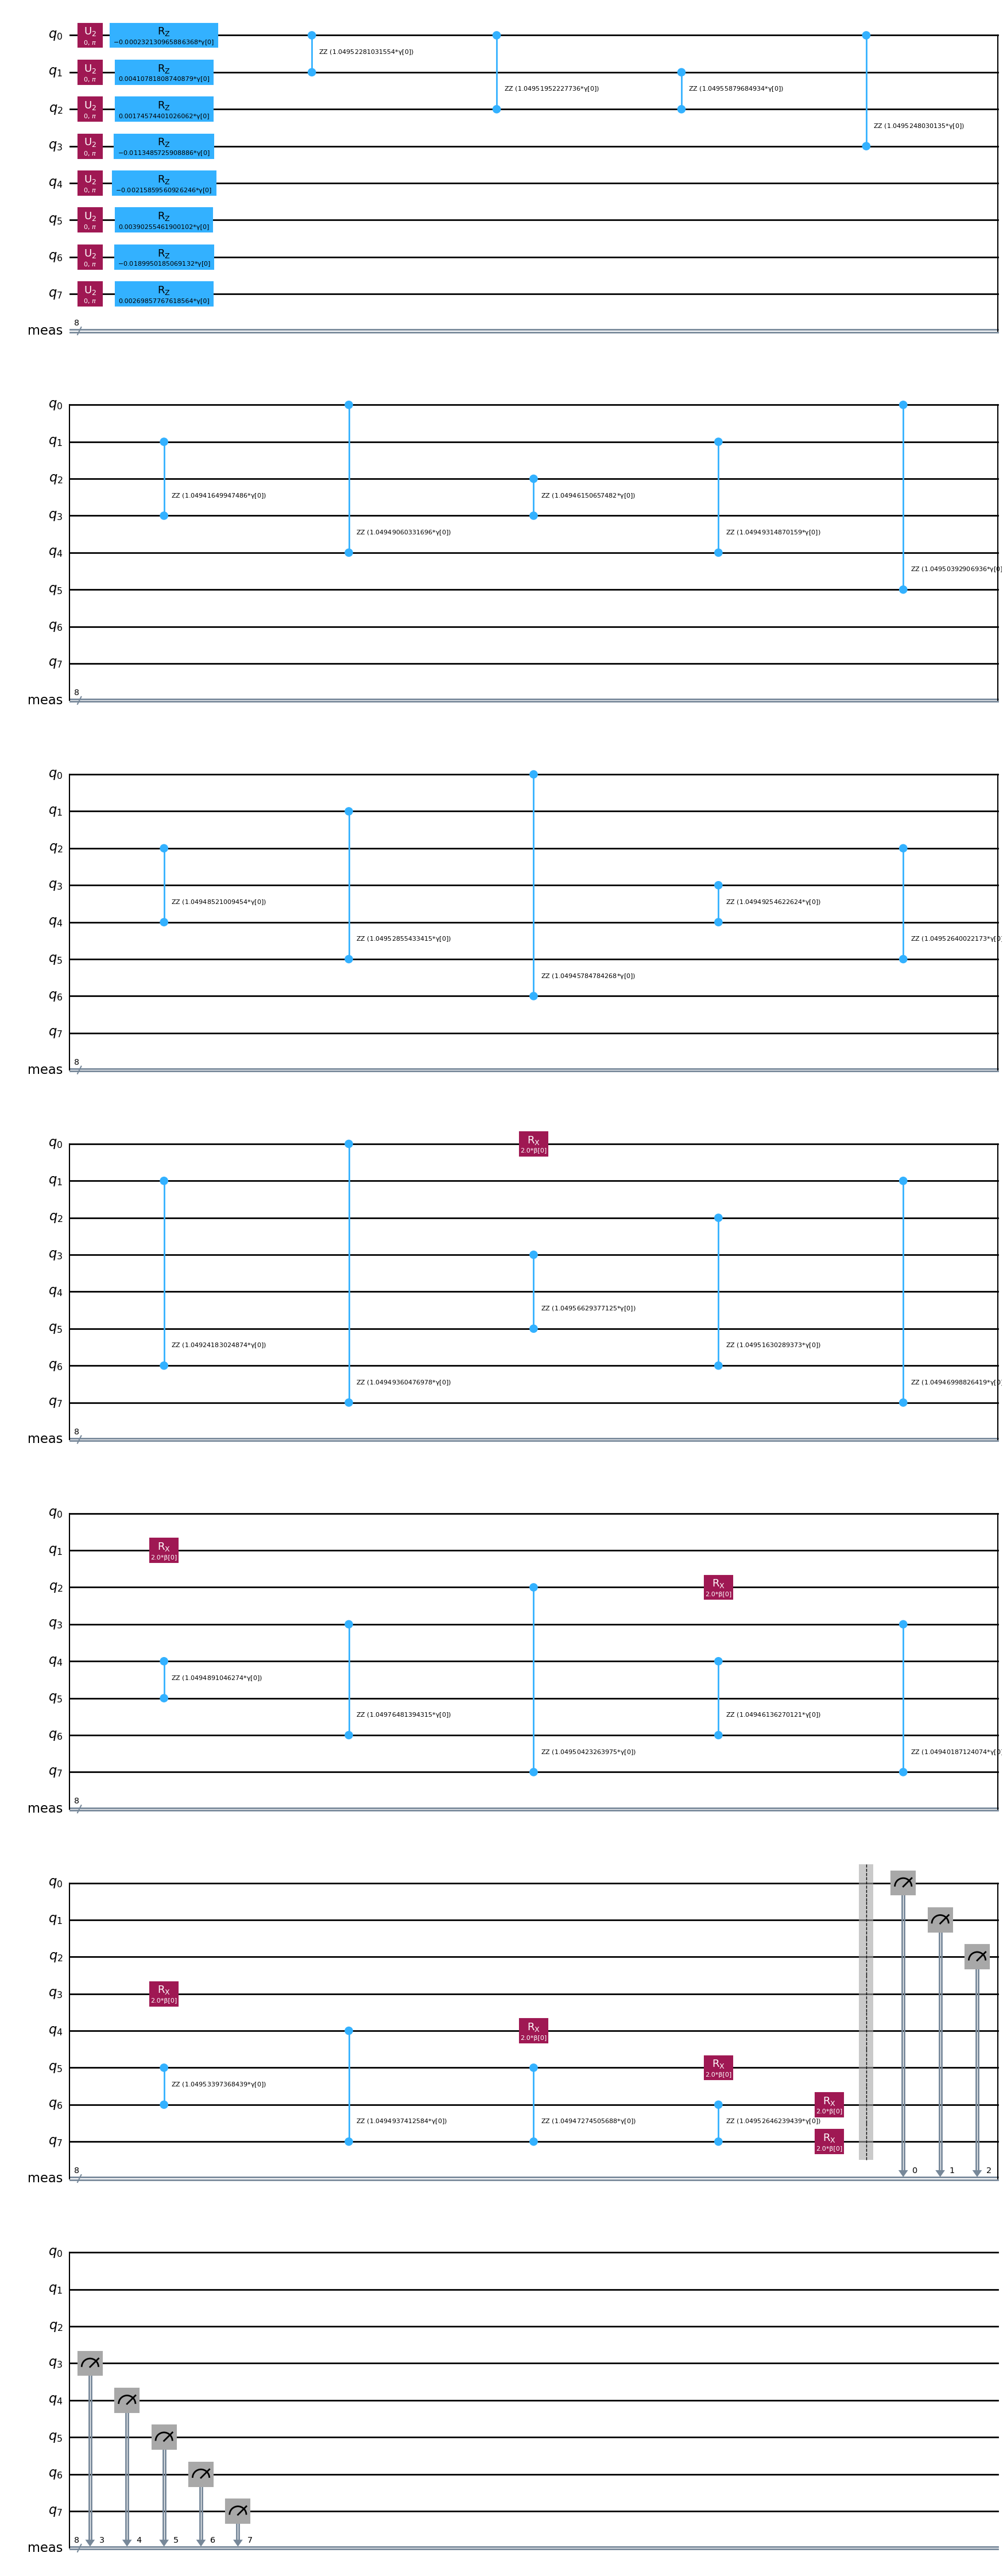

In [ ]:
# TODO aggiornare a versione con noise
algorithm_globals.random_seed = seed

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)


decomposed_circuit = qaoa_mes.ansatz.decompose()
decomposed_circuit.draw("mpl")
# qaoa_mes.ansatz.draw("mpl")
# print_result(result, po)

## Visualizzazione dei risultati

In questa sezione presentiamo tre diversi grafici che aiutano a interpretare e analizzare i risultati ottenuti dall'ottimizzazione del portafoglio.

1. **Grafico a barre: composizione del portafoglio ottimale**
   - Questo grafico mostra quali asset sono stati selezionati nel portafoglio ottimale, con gli asset inclusi aventi valore `1` e quelli esclusi aventi valore `0`.
   - La visualizzazione aiuta a comprendere chiaramente la distribuzione degli asset all'interno del portafoglio in base al modello ottimizzato.

2. **Grafico rischio vs ritorno atteso**
   - Il grafico mostra il valore ottimizzato del portafoglio al variare del fattore di rischio, ovvero il compromesso tra rischio e rendimento.
   - L'asse X rappresenta il fattore di rischio, mentre l'asse Y mostra il valore ottimale ottenuto, evidenziando come l'aumento del rischio impatti sul valore complessivo del portafoglio.

3. **Grafico valore ottimale vs budget**
   - In questo grafico si analizza come il valore ottimale della funzione obiettivo varia al variare del budget, cioè del numero massimo di asset selezionabili nel portafoglio.
   - L'asse X rappresenta il budget, mentre l'asse Y mostra il valore ottimale.
   - Osserviamo che con un budget maggiore, il valore ottimale tende a migliorare (essere meno negativo), ma oltre un certo punto potrebbe saturarsi, indicando che l'inclusione di ulteriori asset non porta a miglioramenti significativi.

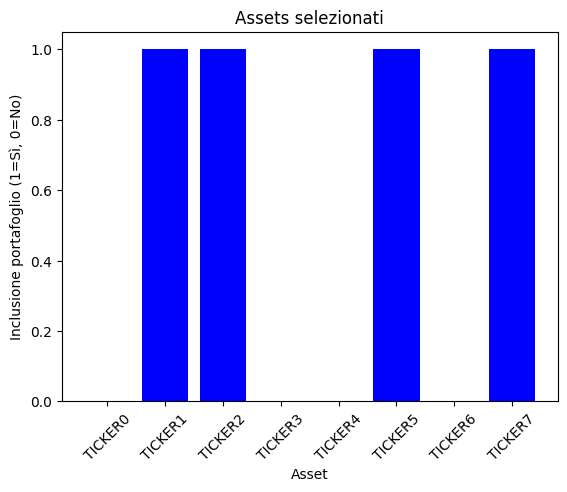

In [37]:
selection = result.x
plt.bar(stocks, selection, color='blue')
plt.title("Assets selezionati")
plt.xlabel("Asset")
plt.ylabel("Inclusione portafoglio (1=Sì, 0=No)")
plt.xticks(rotation=45)
plt.show()

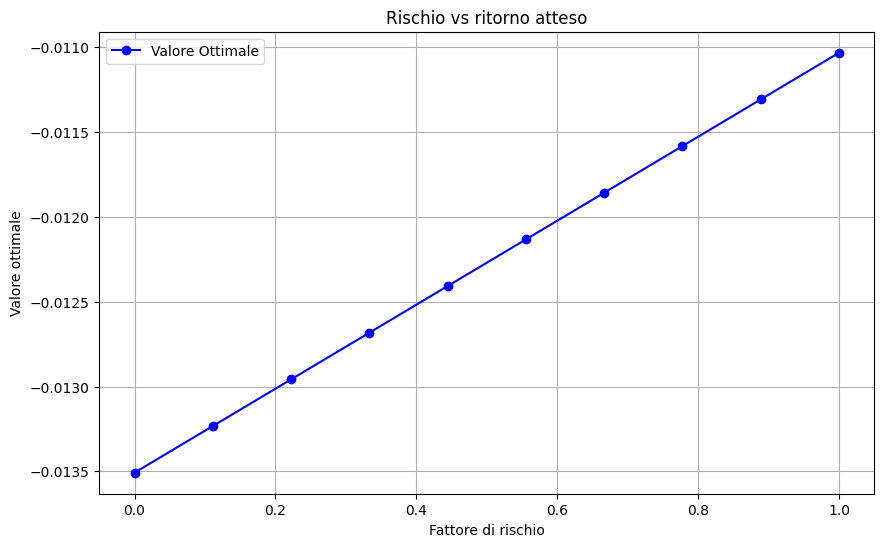

In [38]:
risks = np.linspace(0, 1, 10)
values_per_risk = []

for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    
    result = qaoa.solve(qp)
    
    values_per_risk.append(result.fval)

plt.figure(figsize=(10, 6))
plt.plot(risks, values_per_risk, marker='o', linestyle='-', color='b', label='Valore Ottimale')
plt.title("Rischio vs ritorno atteso")
plt.xlabel("Fattore di rischio")
plt.ylabel("Valore ottimale")
plt.grid(True)
plt.legend()
plt.show()

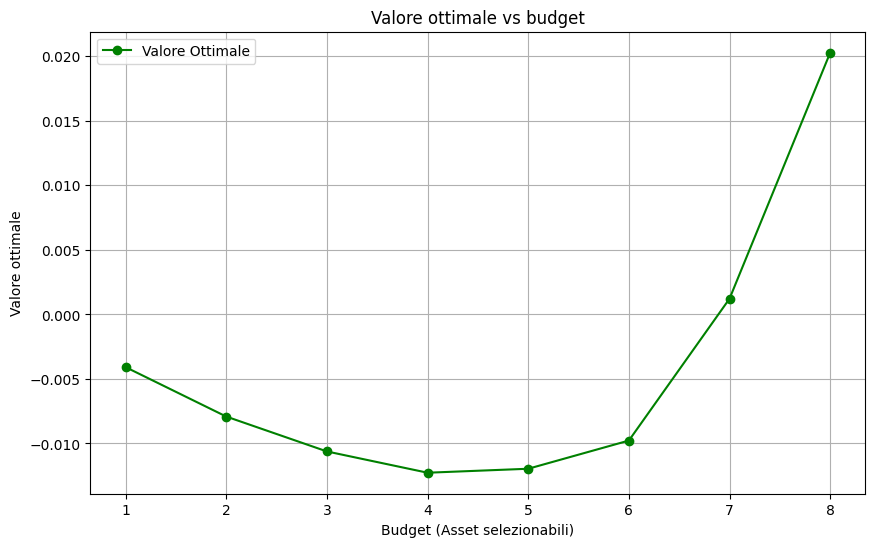

In [39]:
risk = 0.5

budgets = range(1, assets + 1)
values_per_budget = []
selections_per_budget = []

for budget in budgets:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk, budget=budget)
    qp = po.to_quadratic_program()
    
    result = qaoa.solve(qp)
    
    values_per_budget.append(result.fval)
    selections_per_budget.append(result.x)

plt.figure(figsize=(10, 6))
plt.plot(budgets, values_per_budget, marker='o', linestyle='-', color='g', label='Valore Ottimale')
plt.title("Valore ottimale vs budget")
plt.xlabel("Budget (Asset selezionabili)")
plt.ylabel("Valore ottimale")
plt.grid(True)
plt.legend()
plt.show()
